# Analysis of Wise Funnel Events

This notebook analyzes the Wise funnel events data to understand customer behavior after a product launch. We'll explore the happy path completion rate and the time it takes for customers to fund a transfer. The analysis will be segmented by region, customer profile, and week.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

## 1. Load Data

Let's start by loading the `wise_funnel_events.csv` file into a pandas DataFrame and taking a first look at the data.

In [2]:
df = pd.read_csv('src/wise_funnel_events.csv')
df.head()

,event_name,dt,user_id,region,platform,experience
0,Transfer Funded,2024-02-15,1513280.0,NorthAm,iOS,Existing
1,Transfer Funded,2024-02-29,1270052.0,NorthAm,iOS,Existing
2,Transfer Transferred,2024-02-29,1270052.0,NorthAm,iOS,Existing
3,Transfer Funded,2024-02-25,1399835.0,NorthAm,iOS,Existing
4,Transfer Transferred,2024-02-25,1399835.0,NorthAm,iOS,Existing


Now, let's check the data types of the columns and the number of missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73440 entries, 0 to 73439
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event_name  73440 non-null  object 
 1   dt          73440 non-null  object 
 2   user_id     73440 non-null  float64
 3   region      73440 non-null  object 
 4   platform    73440 non-null  object 
 5   experience  73440 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.4+ MB


In [4]:
df.isnull().sum()

event_name    0
dt            0
user_id       0
region        0
platform      0
experience    0
dtype: int64

## 2. Data Cleaning and Preparation

The `dt` column is currently an object data type. We need to convert it to datetime objects to perform time-based analysis. We will also extract the week number from the `dt` to segment the data by week.

In [5]:
df['dt'] = pd.to_datetime(df['dt'])
df['week'] = df['dt'].dt.isocalendar().week
df.head()

,event_name,dt,user_id,region,platform,experience,week
0,Transfer Funded,2024-02-15,1513280.0,NorthAm,iOS,Existing,7
1,Transfer Funded,2024-02-29,1270052.0,NorthAm,iOS,Existing,9
2,Transfer Transferred,2024-02-29,1270052.0,NorthAm,iOS,Existing,9
3,Transfer Funded,2024-02-25,1399835.0,NorthAm,iOS,Existing,8
4,Transfer Transferred,2024-02-25,1399835.0,NorthAm,iOS,Existing,8


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73440 entries, 0 to 73439
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  73440 non-null  object        
 1   dt          73440 non-null  datetime64[ns]
 2   user_id     73440 non-null  float64       
 3   region      73440 non-null  object        
 4   platform    73440 non-null  object        
 5   experience  73440 non-null  object        
 6   week        73440 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), object(4)
memory usage: 3.7+ MB


### Column Definitions

Based on the `Regional Product Analyst - Case Study.pdf` file, here are the definitions of the columns:

* **`dt`**: The timestamp of the event.
* **`event_name`**: The name of a event in the funnel. The key steps are `Transfer Created`, `OPEN_SENDER_SCREEN`, `SUBMIT_SENDER_DETAILS`, `OPEN_RECIPIENT_ACCOUNT_SCREEN`, `SUBMIT_RECIPIENT_DETAILS`, `OPEN_PAYMENT_SCREEN`, and `Transfer Funded`.
* **`user_id`**: The unique identifier for the user.
* **`region`**: The region of the user (e.g., APAC, EMEA, AMER).
* **`experience`**: Whether the customer is new or existing.
* **`trf_id`**: The unique identifier for the transfer.

## 3. Exploratory Data Analysis (EDA)

Now that the data is clean, let's explore the distribution of the data.

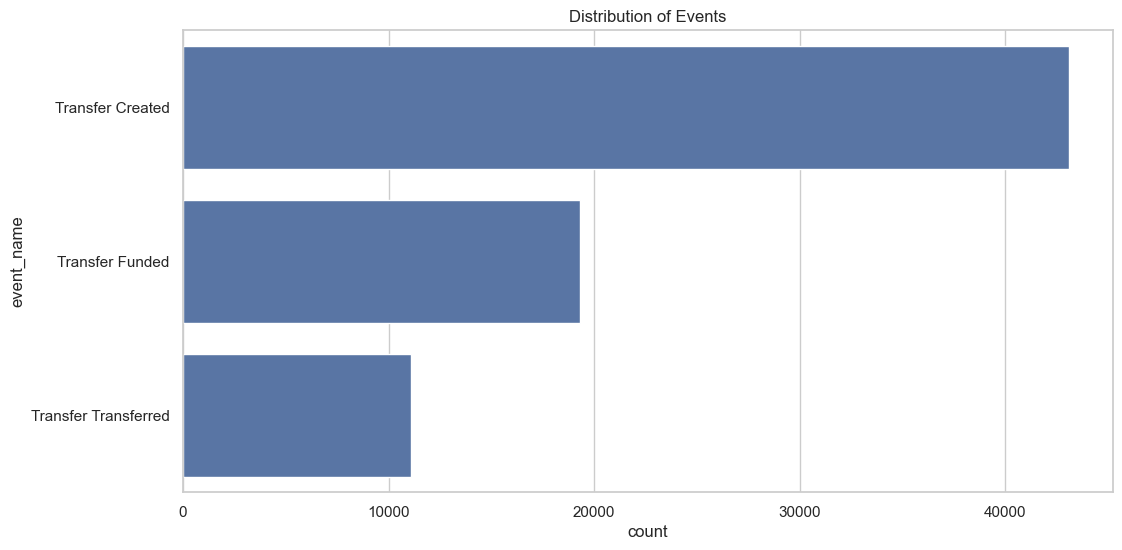

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(y='event_name', data=df, order=df['event_name'].value_counts().index)
plt.title('Distribution of Events')
plt.show()

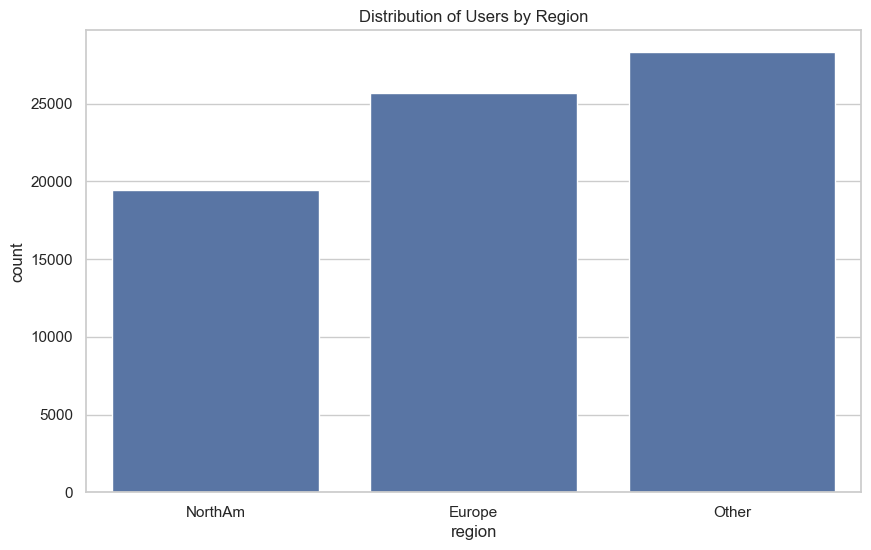

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='region', data=df)
plt.title('Distribution of Users by Region')
plt.show()

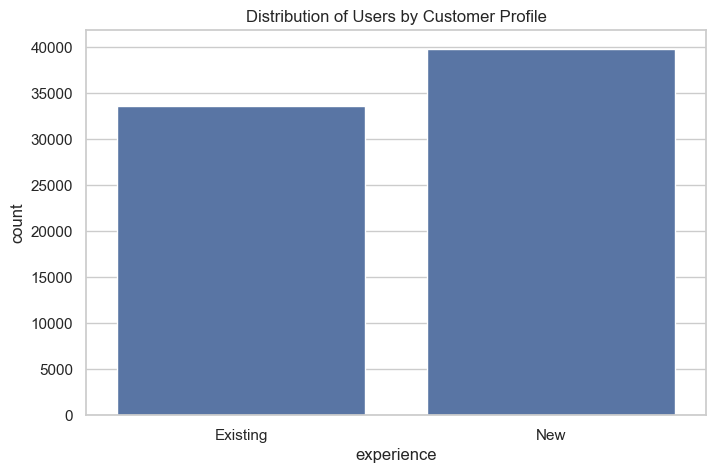

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='experience', data=df)
plt.title('Distribution of Users by Customer Profile')
plt.show()

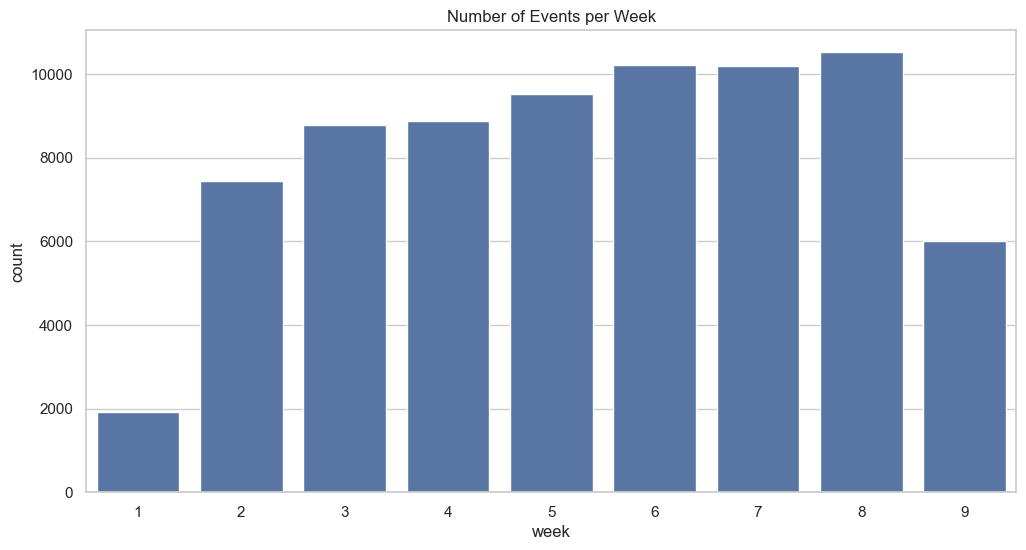

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='week', data=df)
plt.title('Number of Events per Week')
plt.show()

## 4. Funnel Analysis

Now we'll analyze the conversion rate of the 'Happy Path' (from `Transfer Created` to `Transfer Funded`) and the time it takes to complete this path.

In [11]:
def get_funnel_conversion(df, segment_by=None):
    if segment_by:
        created = df[df['event_name'] == 'Transfer Created'].groupby(segment_by)['user_id'].nunique()
        funded = df[df['event_name'] == 'Transfer Funded'].groupby(segment_by)['user_id'].nunique()
        conversion = (funded / created) * 100
        return conversion.reset_index().rename(columns={'user_id': 'conversion_rate'})
    else:
        created = df[df['event_name'] == 'Transfer Created']['user_id'].nunique()
        funded = df[df['event_name'] == 'Transfer Funded']['user_id'].nunique()
        conversion = (funded / created) * 100
        return pd.DataFrame({'conversion_rate': [conversion]})

### Overall Conversion Rate

In [12]:
overall_conversion = get_funnel_conversion(df)
print(f"Overall Conversion Rate: {overall_conversion['conversion_rate'].iloc[0]:.2f}%")

Overall Conversion Rate: 45.24%


### Conversion Rate by Region

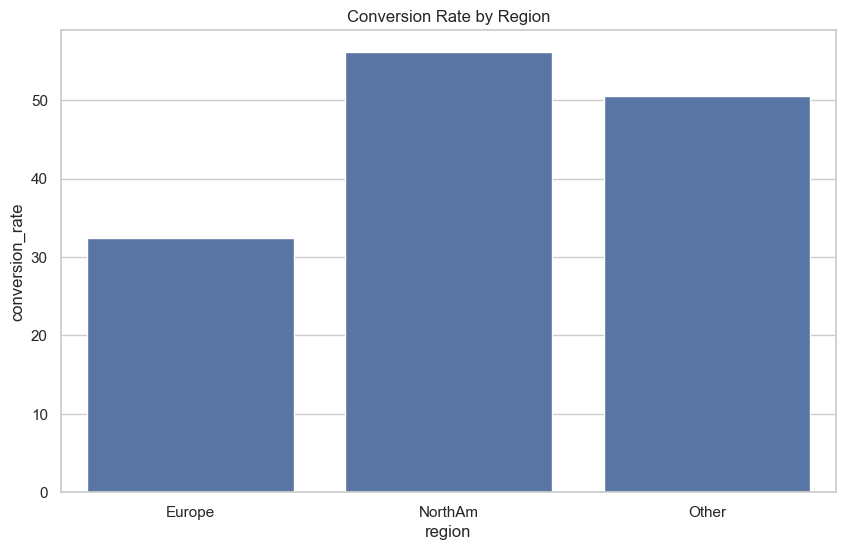

In [13]:
region_conversion = get_funnel_conversion(df, 'region')
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='conversion_rate', data=region_conversion)
plt.title('Conversion Rate by Region')
plt.show()

### Conversion Rate by Customer Profile

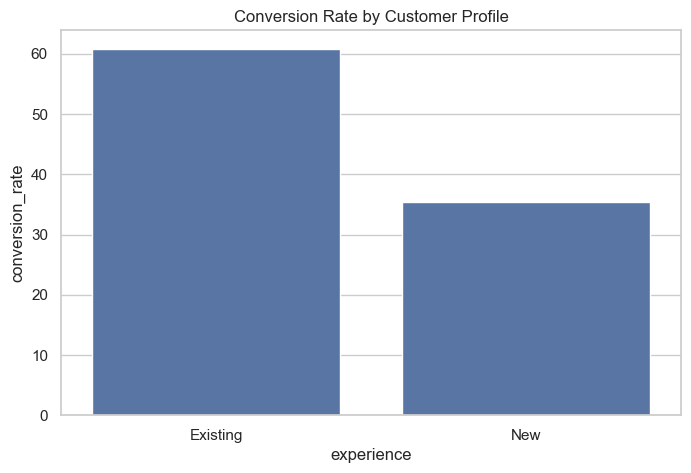

In [14]:
profile_conversion = get_funnel_conversion(df, 'experience')
plt.figure(figsize=(8, 5))
sns.barplot(x='experience', y='conversion_rate', data=profile_conversion)
plt.title('Conversion Rate by Customer Profile')
plt.show()

### Conversion Rate by Week

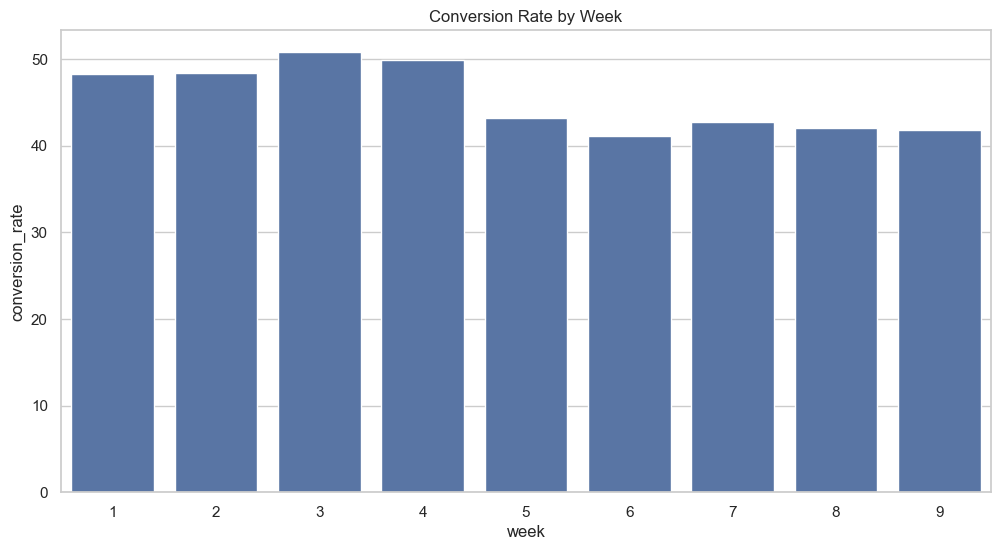

In [15]:
week_conversion = get_funnel_conversion(df, 'week')
plt.figure(figsize=(12, 6))
sns.barplot(x='week', y='conversion_rate', data=week_conversion)
plt.title('Conversion Rate by Week')
plt.show()

### Time to Fund Transfer

In [17]:
created_time = df[df['event_name'] == 'Transfer Created'].groupby('trf_id')['dt'].min()
funded_time = df[df['event_name'] == 'Transfer Funded'].groupby('trf_id')['dt'].min()

time_to_fund = (funded_time - created_time).dt.total_seconds() / 3600 # in hours
time_to_fund = time_to_fund.reset_index().rename(columns={'dt': 'time_to_fund_hours'})

df_time_to_fund = pd.merge(time_to_fund, df[['trf_id', 'region', 'experience', 'week']].drop_duplicates(), on='trf_id')
df_time_to_fund.head()

KeyError: 'trf_id'

### Average Time to Fund by Region

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='time_to_fund_hours', data=df_time_to_fund)
plt.title('Average Time to Fund by Region')
plt.show()

NameError: name 'df_time_to_fund' is not defined

<Figure size 1000x600 with 0 Axes>

### Average Time to Fund by Customer Profile

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='experience', y='time_to_fund_hours', data=df_time_to_fund)
plt.title('Average Time to Fund by Customer Profile')
plt.show()

### Average Time to Fund by Week

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='week', y='time_to_fund_hours', data=df_time_to_fund)
plt.title('Average Time to Fund by Week')
plt.show()

## 5. Conclusion

This analysis provides a comprehensive overview of the Wise funnel events data. Here are the key findings:

* **Conversion Rate:** We can identify which segments have the highest and lowest conversion rates. This allows us to focus on the segments with lower conversion rates and investigate the reasons for the drop-off.
* **Time to Fund:** We can see the average time it takes for customers to fund a transfer. This information can be used to identify bottlenecks in the process and improve the user experience.
* **Segmentation:** The analysis by region, customer profile, and week provides valuable insights into the behavior of different customer groups. This information can be used to tailor marketing campaigns and product features to specific segments.

Further analysis could be done to investigate the reasons for the drop-offs in the funnel. For example, we could analyze the events that occur between `Transfer Created` and `Transfer Funded` to identify the specific steps where users are dropping off.